In [1]:
import datetime
import os
import random
from collections.abc import Iterable
from math import ceil

import plotly.express as px
import plotly.graph_objects as go
import plotly.io
import polars as pl
import polars.selectors as cs
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

2024-05-06 14:54:58.105060: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.15.0


In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
# NOTE Reslults might differ as training was not done in one run

random.seed(3)
tf.random.set_seed(3)

plotly.io.templates.default = "plotly_dark"

In [4]:
# TODO Fourier analysis and correlations -> different notebook

In [5]:
# folder containing the inputs from the competition
INPUT_DIR = os.path.abspath("input")

In [6]:
# TODO move all constants to the beginning

TARGET_LENGTH = 16  # length of the target sequences

# metadata columns = [items on promotion, oil prices, weekday]
METADATA_COLS = ["onpromotion", "dcoilwtico", "weekday"]
FEATURES = 1 + len(METADATA_COLS)  # number of input features

TIMESTEPS = 600  # number of timesteps to use in training

In [7]:
# training hyperparameters
LEARNING_RATE = 1e-4  # TODO adjust?
BATCH_SIZE = 64

# the Kaggle competition uses Root Mean Squared Logarithmic Error
LOSS = tf.keras.losses.MeanSquaredLogarithmicError()

---
# Data preparation

In [8]:
def fill_missing_dates(df: pl.DataFrame) -> pl.DataFrame:
    """Adds the missing dates and fills the missing values."""

    date_df = pl.DataFrame(
        pl.date_range(
            df["date"].min(), df["date"].max(), interval="1d", eager=True
        ).alias("date")
    )

    df = date_df.join(
        df,
        on="date",
        how="outer",
    ).drop("date_right")

    # interpolate and fill backward/forward in case the first/last value is missing
    df = df.interpolate().fill_null(strategy="backward").fill_null(strategy="forward")

    return df

In [9]:
# read and complete the dataframe containing the oil prices
oil_df = pl.read_csv(os.path.join(INPUT_DIR, "oil.csv"), try_parse_dates=True)
oil_df = fill_missing_dates(oil_df)

In [10]:
# read the training dataframe
train_df = pl.read_csv(os.path.join(INPUT_DIR, "train.csv"), try_parse_dates=True)
train_df = train_df.drop("id")  # we do not need the id

# keep only the chosen number of timesteps plus TARGET_LENGTH steps to use as test set
train_df = train_df.filter(
    pl.col("date")
    > train_df["date"].max() - datetime.timedelta(TIMESTEPS + TARGET_LENGTH)
)

# partition the training data into dataframes for each (store_nbr, family) pair
dataframes = train_df.partition_by(
    ["store_nbr", "family"], include_key=False, as_dict=True
)

# fill missing dates and add oil prices and weekday signal to each dataframe
for key, df in dataframes.items():
    dataframes[key] = (
        fill_missing_dates(df)
        .join(oil_df, on="date", how="inner")
        .with_columns(pl.col("date").dt.weekday().alias("weekday"))
        .with_columns(cs.numeric().cast(pl.Float32))  # cast numeric columns to Float32
    )

In [11]:
# Create test dataframes to evaluate our models after training
# The test dataframes simulate the targets (from test.csv), except that
# we have the values of the 'sales' column (to compare with our predictions).

test_dataframes = {}

# use the last TARGET_LENGTH timesteps of each dataframe as test set
for key, df in dataframes.items():
    test_dataframes[key] = df.tail(TARGET_LENGTH)
    dataframes[key] = df.head(-TARGET_LENGTH)

In [12]:
print("columns:", dataframes[key].columns)
print("training dataframes shape:", dataframes[key].shape)
print("test dataframes shape    :", test_dataframes[key].shape)

columns: ['date', 'sales', 'onpromotion', 'dcoilwtico', 'weekday']
training dataframes shape: (600, 5)
test dataframes shape    : (16, 5)


In [13]:
# TODO Only need to add the values from test.csv for the predictions, not for training
# NOTE call 'target_df' to avoid confusion with the test dataframes (taken from train.csv)

# target_df = pl.read_csv(os.path.join(INPUT_DIR, "test.csv"), try_parse_dates=True)

# # Add a 'sales' column filled with null values to the test dataframe
# target_df = target_df.with_columns(pl.lit(None).alias("sales")).select(train_df.columns)

# # Concatenate the dataframes so that the training dataframe contains all time steps
# train_df = pl.concat([train_df, target_df])

---
# Filtering

In [14]:
# NOTE zero-tail series
# filter out all series having their tail uniformly zero

ZERO_TAIL_LENGTH = 16

zero_tail_dataframes = {
    key: df
    for key, df in dataframes.items()
    if df.tail(ZERO_TAIL_LENGTH).select("sales").sum().item() == 0
}

for key in zero_tail_dataframes.keys():
    _ = dataframes.pop(key)

print("drop:", len(zero_tail_dataframes), "| remaining:", len(dataframes))

drop: 116 | remaining: 1666


In [15]:
%%script echo skipping

# plot a random series with zero-tail
df = zero_tail_dataframes[random.sample(sorted(zero_tail_dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


In [16]:
# NOTE series with gaps
# filter out all series having a gap of at least `GAP_LENGTH` timesteps (= 0)

# minimum gap length
GAP_LENGTH = 32

gap_dataframes = {
    key: df
    for key, df in dataframes.items()
    if df.with_columns(pl.col("sales").rolling_mean(window_size=GAP_LENGTH))[
        "sales"
    ].min()
    == 0.0
}

for key in gap_dataframes.keys():
    _ = dataframes.pop(key)

print("drop:", len(gap_dataframes), "| remaining:", len(dataframes))

drop: 188 | remaining: 1478


In [17]:
%%script echo skipping

# plot a random series with a gap
df = gap_dataframes[random.sample(sorted(gap_dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


In [18]:
%%script echo skipping

# plot a random series from the remaining keys
df = dataframes[random.sample(sorted(dataframes.keys()), 1)[0]]
px.line(data_frame=df, x="date", y="sales")

skipping


---
# MODEL DEFINITION
---

In [19]:
# NOTE Notation:
# NOTE - S = sales
# NOTE - M = (M_1, M_2, ...) = vector of metadata variables
# NOTE - Z(t) = value of variable Z at timestep t

# NOTE Ansatz: there exists a random variable X which underlies S
# NOTE in the sense that S = f(X, M) for some function f.

# NOTE We consider windows (sequences of consecutive timesteps) composed of N+T timesteps
# NOTE and split into two parts
# NOTE (t_(-N-1), ..., t_0) of N = input_length timesteps   ->  x-window (xW)
# NOTE (t_1, ..., t_T)      of T = TARGET_LENGTH timesteps  ->  y-window (yW)
#
# NOTE We have the values of all metadata variables on the entire window and the values of S on the x-window.
# NOTE We want to predict the values of S on the y-window.

# NOTE We proceed in three steps:
# NOTE 1. DECOUPLING: extract the value of the underlying variable X on the x-window from those of S and M
# NOTE   {S(t), M(t) : t in xW} -> {X(t) : t in xW}
# NOTE 2. TIME SERIES PREDICTION: predict the values of X on the y-window from its values on the x-window
# NOTE   {X(t) : t in xW} -> {X(t) : t in yW}
# NOTE 3. COUPLING: combine X with the metadata to obtain the values of S on the y-window
# NOTE   {X(t), M(t) : t in yW} -> {S(t) : t in yW}
# NOTE Each arrow represents a neural network and takes the values of the previous network as input.
#
# NOTE The process can be summarized as:
# NOTE [S(xW), M(xW)] -> |DECOUPNET| -> X(xW) -> |TIMENET| -> X(yW) -> [X(yW), M(yW)] -> |COUPNET| -> S(yW)

# NOTE We will use dense models to do the coupling/decoupling and try different architectures for the TS prediction.

In [20]:
# NOTE Create decoupling/coupling networks to use in all models.
# NOTE We choose simple architectures under the assumption that the coupling relation
# NOTE (the function f above) is not very complicated.

decoupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1),
    ],
    name="DecoupNet",
)

# NOTE Initializing the kernel of the last layers with ones avoids the model
# NOTE getting stuck and not learning, which can happen if the kernel weights
# NOTE are too close to zero. In that case, the outputs are close to zero
# NOTE and the model cannot take large enough steps to learn.
# NOTE This sometimes happens with the default initializer 'glorot_uniform'
# NOTE (and happens every time if we initialize with 'zeros').

coupling_net = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(TARGET_LENGTH, FEATURES)),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1, kernel_initializer="ones"),
    ],
    name="CoupNet",
)

In [21]:
def make_model(timenet: tf.keras.Model, name: str) -> tf.keras.Model:
    # create instances of the decoupling/coupling networks to use in the model
    dcnet = tf.keras.models.clone_model(decoupling_net)
    cnet = tf.keras.models.clone_model(coupling_net)

    # variable names are in the form `window_var`
    x_win = tf.keras.Input(shape=(None, FEATURES), name="x-window")
    y_m = tf.keras.Input(shape=(TARGET_LENGTH, FEATURES - 1), name="y-metadata")

    x_x = dcnet(x_win)
    y_x = timenet(x_x)
    y_xm = tf.keras.layers.Concatenate(axis=-1, name="y-concat")([y_x, y_m])
    y_s = cnet(y_xm)

    model = tf.keras.Model(inputs=[x_win, y_m], outputs=y_s, name=name)

    model.compile(
        loss=LOSS, optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    )

    return model

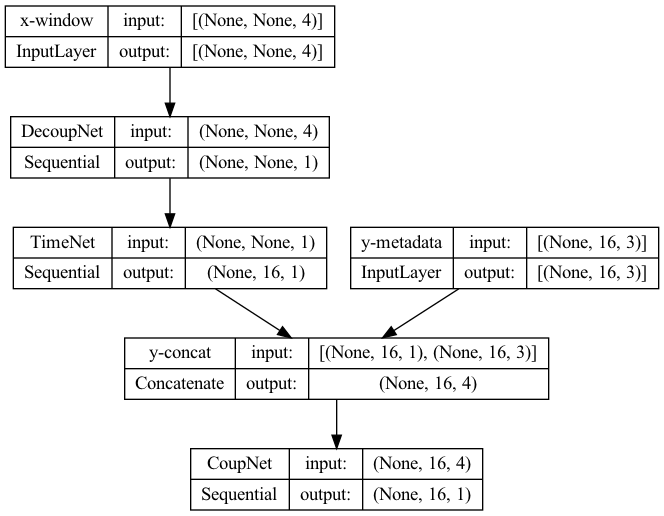

In [22]:
# make a dummy TimeNet to illustrate the architecture
dummy_timenet = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(None, 1)),
        tf.keras.layers.Lambda(lambda xs: xs[-TARGET_LENGTH:]),
        tf.keras.layers.Reshape((TARGET_LENGTH, 1)),
    ],
    name="TimeNet",
)

dummy_model = make_model(dummy_timenet, name="dummy")

tf.keras.utils.plot_model(dummy_model, show_shapes=True)

---
# DATASET CREATION
---

In [23]:
# NOTE A window is window_length = input_length + TARGET_LENGTH timesteps of consecutive data from a dataframe.
# NOTE Each window produces one (input, target) pair, where
# NOTE - target = y-window metadata
# NOTE - input = (x-window, y-window metadata)

# NOTE For a single key, the number of windows is window_count = TIMESTEPS - window_length + 1.
# NOTE The total number of elements in the dataset is thus ceil(window_count * len(keys) / BATCH_SIZE).

# NOTE Having `batch` before `map` gives a marginal performance increase
# NOTE see https://www.tensorflow.org/guide/data_performance
# NOTE verified in practice

In [24]:
class KeysDataset(tf.data.Dataset):
    @tf.function
    def _split_batch_window(window: tf.Tensor):
        # split window into x-window and y-window - keep the batches
        x_win = window[:, :-TARGET_LENGTH]
        y_win = window[:, -TARGET_LENGTH:]

        y_s = tf.gather(y_win, indices=[0], axis=-1)
        y_m = tf.gather(y_win, indices=[1, 2, 3], axis=-1)

        return (x_win, y_m), y_s

    def _generator(window_length: int, window_count: int, xs: tf.Tensor):
        for key_ind in range(xs.shape[0]):
            for window_ind in range(window_count):
                yield xs[key_ind, window_ind : window_ind + window_length]

    def __new__(
        cls, input_length: int, keys: Iterable[tuple[int, str]], steps: int, train: bool
    ) -> tf.data.Dataset:
        dfs = [dataframes[key].select(["sales"] + METADATA_COLS) for key in keys]

        if train:
            dfs = [df.head(steps) for df in dfs]
        else:
            dfs = [df.tail(steps) for df in dfs]

        window_length = input_length + TARGET_LENGTH
        window_count = len(dfs[0]) - window_length + 1
        window_spec = tf.TensorSpec(shape=(window_length, FEATURES), dtype=tf.float32)

        # concatenate all data into one tensor -> (keys, timesteps, features)
        xs = tf.concat([tf.expand_dims(df, 0) for df in dfs], axis=0)

        ds = tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=window_spec,
            args=(window_length, window_count, xs),
        )

        ds = (
            ds.batch(BATCH_SIZE)
            .map(cls._split_batch_window, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
        )

        return ds

In [25]:
# NOTE Note on the train/valid split of the KeysDatasets
#
# NOTE Because of how the windowing works, if we split the dataframes into
# NOTE train/valid dataframes with the selected training ratio, the resulting
# NOTE datasets can be split very differently.
# NOTE The number of windows in a dataset of length T is T - window_length + 1,
# NOTE so if we were to start with 600 timesteps and split them with 0.8 train ratio
# NOTE we would get 480/120 train/valid timestes. If the input length is 96,
# NOTE the number of train/valid windows (for a single key) is 369/9,
# NOTE which is a 41/1 split.
#
# NOTE For this reason, we do not split the dataframe directly using the ratio
# NOTE but instead compute the number of train/valid timesteps needed
# NOTE so that the split of train/valid windows matches the chosen ratio.

In [26]:
# NOTE The number of windows available with T timesteps is T - window_length + 1.


class KeysDatasets:
    def __init__(
        self,
        input_length: int,
        keys: Iterable[tuple[int, str]],
        train_ratio: float = 0.8,
    ):
        window_length = input_length + TARGET_LENGTH
        total_windows = TIMESTEPS - 2 * window_length + 2  # train + valid windows

        train_windows = int(total_windows * train_ratio)
        valid_windows = total_windows - train_windows

        train_timesteps = train_windows + window_length - 1
        valid_timesteps = valid_windows + window_length - 1

        # make training and validation datasets
        self.train = KeysDataset(input_length, keys, train_timesteps, train=True)
        self.valid = KeysDataset(input_length, keys, valid_timesteps, train=False)

        # compute the number of batches in each dataset
        self.train_batches = ceil(train_windows * len(keys) / BATCH_SIZE)
        self.valid_batches = ceil(valid_windows * len(keys) / BATCH_SIZE)

    @property
    def length(self) -> dict[str, int]:
        return {"train": self.train_batches, "valid": self.valid_batches}

---
# Training loop
---

In [27]:
# NOTE The train datasets obtained by taking all the key are
# NOTE fairly large (between 8.5k and 10k batches).
#
# NOTE To smoothen the training process, we split each epoch
# NOTE (one pass through the entire train dataset) into epoch_split parts.
# NOTE This gives epoch * epoch_split split epochs, which is the number of
# NOTE epochs that we pass to `model.fit()`.
# NOTE Each split epoch trains on ds.length['train'] // epoch_split batches.
# NOTE We need `ds.train.repeat()` in `model.fit()` to be able to loop over
# NOTE the (full) training dataset more than once.
#
# NOTE This is (up to rounding) equivalent to training for `epoch` epochs
# NOTE without splitting the dataset. However, doing so makes for very large epochs
# NOTE (~10k batches), which makes the saving and evaluating happen less often.
#
# NOTE The valid dataset is not split, so the validation loss does reflect the
# NOTE model's progress over time, but the training loss might not.

In [28]:
# NOTE Monitor training via TensorBoard by running
# NOTE tensorboard --logdir log/tensorboard

In [29]:
def train(
    model: tf.keras.Model,
    ds: KeysDatasets,
    epochs: int,
    epoch_split: int,
    selection: bool = False,
):
    split_epochs = epochs * epoch_split  # number of epochs to pass to model.fit()
    steps_per_epoch = ds.length["train"] // epoch_split  # steps per split epoch

    history_dir = "selection" if selection else "history"

    csv_logger = tf.keras.callbacks.CSVLogger(
        filename=os.path.join("log", history_dir, f"{model.name}.csv"), append=False
    )

    callbacks = [csv_logger]

    if not selection:
        os.makedirs(os.path.join("models"), exist_ok=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join("models", f"{model.name}.keras")
        )

        # # NOTE save weights only if trainig on Kaggle
        # os.makedirs(os.path.join("models", "weights", model.name), exist_ok=True)
        # checkpoint = tf.keras.callbacks.ModelCheckpoint(
        #     filepath=os.path.join(
        #         "models", "weights", model.name, model.name + "-{epoch:03d}.weights.h5"
        #     ),
        #     save_weights_only=True,
        # )

        os.makedirs(os.path.join("log", "tensorboard", model.name), exist_ok=True)
        tb_logger = tf.keras.callbacks.TensorBoard(
            log_dir=os.path.join("log", "tensorboard", model.name)
        )

        # train for at least half the epochs before possibly stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, start_from_epoch=(split_epochs // 2)
        )

        callbacks += [checkpoint, tb_logger, early_stopping]

    _ = model.fit(
        ds.train.repeat(),
        validation_data=ds.valid,
        epochs=split_epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
    )

---
# MODEL SELECTION
---

In [30]:
# make a folder to store the training logs of the selection process
os.makedirs(os.path.join("log", "selection"), exist_ok=True)

In [31]:
# TODO clean cell

SELECT_EPOCHS = 5  # number of epochs for selection
SELECT_EPOCH_SPLIT = 4

# NOTE During the selection phase, we train the models on a small sample of keys only
# NOTE in order to speed up the process.

KEY_SAMPLE_RATIO = 0.1  # ratio of keys to use during selection

key_sample = random.sample(
    list(dataframes.keys()), int(len(dataframes) * KEY_SAMPLE_RATIO)
)

INPUT_LENGTHS = (32, 64, 96)

# make a pair of (train, valid) datasets for each input length
kds = {
    input_length: KeysDatasets(input_length, key_sample)
    for input_length in INPUT_LENGTHS
}

In [32]:
def plot_selection_metric(model_root_name: str, metric: str = "val_loss") -> go.Figure:
    logs = {
        os.path.splitext(file)[0]: os.path.join("log", "selection", file)
        for file in sorted(os.listdir(os.path.join("log", "selection")))
        if file.split("-")[0] == model_root_name
    }

    metric_df = pl.concat(
        [
            pl.read_csv(log).select(metric).rename(lambda _: name)
            for name, log in logs.items()
        ],
        how="horizontal",
    ).with_row_index("epoch")

    plot = px.line(
        data_frame=metric_df,
        x="epoch",
        y=list(logs.keys()),
        log_y=True,
        title=f"logarithmic {metric} of {model_root_name} models",
        markers=True,
    )

    return plot

## Dense models

- pros: reasonably fast to train
- cons: fixed input length

In [33]:
def make_dense_model(depth: int, width: int, input_length: int = 64) -> tf.keras.Model:
    name = f"DENS-{depth}{width}"

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(input_length, 1)))

    for _ in range(depth):
        timenet.add(tf.keras.layers.Dense(units=width, activation="relu"))

    timenet.add(tf.keras.layers.Flatten())
    timenet.add(tf.keras.layers.Dense(TARGET_LENGTH))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [34]:
%%script echo skipping

DENS_ARCHS = [(1, 16), (2, 16), (2, 32), (3, 16)]

for arch in DENS_ARCHS:
    model = make_dense_model(*arch, input_length=32)

    train(
        model,
        kds[32],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [35]:
plot_selection_metric("DENS")

## Convolutional models

- pros: independent of input length
- cons: 

In [36]:
# TODO fix architecture to allow for wider models - for now only 16 filters work


def make_conv_model(arch: Iterable[int], filters: int = 16) -> tf.keras.Model:
    name = "CONV-" + "".join(str(x) for x in arch)

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for ks in arch:
        timenet.add(tf.keras.layers.Conv1D(filters, kernel_size=ks, activation="relu"))

    timenet.add(tf.keras.layers.Lambda(lambda xs: xs[:, -1, :]))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [37]:
%%script echo skipping

# NOTE The minimal input length for a conv model with architecture
# NOTE (x1, x2, ...) is TARGET_LENGTH + sum_i (xi-1).

# min input lengths: [20, 22, 28, 32]
CONV_ARCHS = [(2, 2, 2, 2), (3, 3, 3), (3, 3, 5, 5), (5, 7, 7)]


for kernel_sizes in CONV_ARCHS:
    model = make_conv_model(kernel_sizes)

    train(
        model,
        kds[32],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [38]:
plot_selection_metric("CONV")

## LSTM models

- pros: independent of input length
- cons: slow

In [39]:
def make_lstm_model(depth: int, width: int) -> tf.keras.Model:
    name = f"LSTM-{depth}{width}"

    timenet = tf.keras.Sequential(name="TimeNet-" + name)
    timenet.add(tf.keras.Input(shape=(None, 1)))

    for _ in range(depth):
        timenet.add(tf.keras.layers.LSTM(width, return_sequences=True))

    timenet.add(tf.keras.layers.LSTM(TARGET_LENGTH, return_sequences=False))
    timenet.add(tf.keras.layers.Reshape((TARGET_LENGTH, 1)))

    return make_model(timenet, name=name)

In [40]:
%%script echo skipping

LSTM_ARCHS = [(2, 16), (4, 16), (2, 32), (4, 32)]

for arch in LSTM_ARCHS:
    model = make_lstm_model(*arch)

    train(
        model,
        kds[32],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [41]:
plot_selection_metric("LSTM")

## Comparison of input lengths

In [42]:
%%script echo skipping

for input_length in INPUT_LENGTHS:
    model = make_dense_model(*(3, 16), input_length=input_length)
    model._name = "iDENS-" + str(input_length)

    train(
        model,
        kds[input_length],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

skipping


In [43]:
plot_selection_metric("iDENS")

In [44]:
# TODO LSTM training input length comparison

In [47]:
%%script echo skipping

il_lstm_models = dict()

for input_length in INPUT_LENGTHS:
    model = make_lstm_model(4, 32)
    model._name = "iLSTM-" + str(input_length)

    train(
        model,
        kds[input_length],
        epochs=SELECT_EPOCHS,
        epoch_split=SELECT_EPOCH_SPLIT,
        selection=True,
    )

    il_lstm_models[input_length] = model  # store the model for evaluation

skipping


In [46]:
plot_selection_metric("iLSTM")

In [86]:
%%script echo skipping

# evaluate the models trained on the different input lengths on each input length
df_LSTM_IL = pl.DataFrame(
    {
        f"train IL {key}": [
            model.evaluate(kds[eval_length].valid, verbose=0)
            for eval_length in INPUT_LENGTHS
        ]
        for key, model in il_lstm_models.items()
    }
).insert_column(0, pl.Series("eval IL", INPUT_LENGTHS))

# save the dataframe to avoid having to run the computation again if the plot is cleared
df_LSTM_IL.write_csv(os.path.join("log", "selection", "iLSTM_df.csv"))

skipping


In [80]:
df_LSTM_IL = pl.read_csv(os.path.join("log", "selection", "iLSTM_df.csv"))

fig = go.Figure()

for col in df_LSTM_IL.drop("eval IL").columns:
    fig.add_trace(go.Bar(x=df_LSTM_IL["eval IL"], y=df_LSTM_IL[col], name=col))

fig.update_layout(
    title="LSTM models: training vs. evaluation input length",
    xaxis_title="evaluation IL",
    yaxis_title="error",
)

fig.show()

---

In [47]:
# TODO REDO

# NOTE MODEL SELECTION
#
# NOTE train the TIER-1 models and submit prediction
# NOTE if performance is not good, try the TIER-2 models
#
# NOTE TIER-1 models:
# NOTE - DENS-96    -> best DENS, best overall (on IL = 96 only)
# NOTE - CONV-5577  -> best CONV (min IL = 36 -> train IL = 36)
# NOTE - LSTM-232   -> best LSTM, most versatile
#
# NOTE TIER-2 models:
# NOTE - DENS-64    -> almost as good as DENS-96, more versatile
# NOTE - CONV-333   -> fast and almost as good as best CONV model (min IL = 22)
# NOTE - LSTM-432   -> highest potential?

---
# TRAINING
---

In [48]:
# make a folder to store the training logs
os.makedirs(os.path.join("log", "history"), exist_ok=True)

In [49]:
TRAIN_EPOCHS = 10
TRAIN_EPOCH_SPLIT = 20

In [50]:
def plot_training_history(model_name: str) -> go.Figure:
    df = pl.read_csv(os.path.join("log", "history", f"{model_name}.csv"))

    fig = px.line(
        data_frame=df,
        x="epoch",
        y=["loss", "val_loss"],
        log_y=True,
        title=f"training history of model {model_name}",
    )

    # add a marker indicating the lowest val_loss
    min_df = df.filter(pl.col("val_loss") == pl.col("val_loss").min())
    epoch, val_loss = min_df["epoch"][0], min_df["val_loss"][0]

    fig.add_trace(
        go.Scatter(
            x=[epoch],
            y=[val_loss],
            mode="markers",
            marker_size=10,
            marker_symbol="circle",
            name="min val_loss",
        )
    )

    return fig

---

In [50]:
# TODO test the performance of the best model so far

models = dict()

In [56]:
%%script echo skipping

model = make_dense_model(*(4, 16), input_length=64)
train(model, kds[64], epochs=TRAIN_EPOCHS, epoch_split=TRAIN_EPOCH_SPLIT)

skipping


In [55]:
plot_training_history("DENS-416")

In [51]:
%%script echo skipping

models["DENS-316"] = make_dense_model(*(3, 16), input_length=96)
train(models["DENS-316"], kds[96], epochs=TRAIN_EPOCHS, epoch_split=TRAIN_EPOCH_SPLIT)

skipping


In [70]:
# plot_training_history("DENS-316")

In [67]:
%%script echo skipping

models["CONV-33355"] = make_conv_model((3, 3, 3, 5, 5))
train(models["CONV-33355"], kds[32], epochs=TRAIN_EPOCHS, epoch_split=TRAIN_EPOCH_SPLIT)

skipping


In [69]:
# plot_training_history("CONV-33355")

---
# EVALUATION
---

In [58]:
# TODO add the 'gap' dataframes back to the 'dataframes' dict

In [58]:
# gather all data necessary to predict the test set in `dataframes`
for key in dataframes.keys():
    dataframes[key] = pl.concat([dataframes[key], test_dataframes[key]], how="vertical")

# delete the test dataframes to avoid concatenating again if the cell runs again
del test_dataframes

In [59]:
def make_inputs(key: str, input_length: int) -> tuple[tf.Tensor, tf.Tensor]:
    """Makes the inputs pair corresponding to the last window of `dataframe[key]`."""

    # select and scale the last window of the dataframe
    df = (
        dataframes[key]
        .select(["sales"] + METADATA_COLS)
        .tail(input_length + TARGET_LENGTH)
    )

    # make the inputs and convert them to tensors with batch dimension
    # 1st input: x-window sales and metadata values
    # 2nd input: y-window metadata values
    x_win = tf.expand_dims(df.head(input_length), 0)
    y_m = tf.expand_dims(df.tail(TARGET_LENGTH).select(METADATA_COLS), 0)

    return (x_win, y_m)

In [60]:
def predict(model: tf.keras.Model, key: str, input_length: int) -> pl.DataFrame:
    pred = model(make_inputs(key, input_length))
    pred_df = pl.DataFrame({"sales": tf.squeeze(pred).numpy()})

    return pred_df

---

In [63]:
def evaluate_model(model: tf.keras.Model, input_length: int) -> pl.DataFrame:
    preds = pl.DataFrame(
        {f"{key}": predict(model, key, input_length) for key in dataframes.keys()}
    )

    rmsle_df = pl.DataFrame(
        {
            f"{key}": LOSS(
                tf.squeeze(preds[f"{key}"]),
                tf.squeeze(dataframes[key].tail(TARGET_LENGTH)["sales"]),
            )
            ** 0.5
            for key in dataframes.keys()
        }
    )

    return rmsle_df.transpose(column_names=[model.name]).describe()

In [65]:
model = tf.keras.models.load_model("models/DENS-416.keras", safe_mode=False)
evaluate_model(model, input_length=64)

statistic,DENS-416
str,f64
"""count""",1478.0
"""null_count""",0.0
"""mean""",0.375592
"""std""",0.238977
"""min""",0.08307
"""25%""",0.201825
"""50%""",0.329608
"""75%""",0.501182
"""max""",2.842604


In [66]:
model = tf.keras.models.load_model("models/CONV-33355.keras", safe_mode=False)
evaluate_model(model, input_length=32)

statistic,CONV-33355
str,f64
"""count""",1478.0
"""null_count""",0.0
"""mean""",0.599759
"""std""",0.287189
"""min""",0.123213
"""25%""",0.370369
"""50%""",0.546405
"""75%""",0.792092
"""max""",2.141709
